In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import RidgeCV, LogisticRegressionCV
from nltk.corpus import stopwords
from wordcloud import WordCloud

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

## Load data

In [2]:
df = pd.read_csv('../data/billboard-lyrics-spotify.csv')
df.sample(3)

artist_all               artist_base  rank  \
2730                   madonna                   madonna    30   
1715  electric light orchestra  electric light orchestra    15   
2461              the jacksons              the jacksons    61   

                 song  year artist_featured       song_clean  \
2730  open your heart  1987             NaN  open your heart   
1715   telephone line  1977             NaN   telephone line   
2461   state of shock  1984             NaN   state of shock   

                  artist_clean  \
2730                   madonna   
1715  electric light orchestra   
2461              the jacksons   

                                                 lyrics  danceability  ...  \
2730   i see you on the street and you walk on by yo...         0.656  ...   
1715  hello how are you have you been alright throug...         0.467  ...   
2461  yeah come on baby you gotta be mine cause your...         0.980  ...   

        tempo  time_signature  popularity  explicit  duration_min  num_words  \
2730  113.239             4.0        29.0     False      3.821333      349.0   
1715   70.856             4.0        63.0     False      4.672667      139.0   
2461  121.558             4.0        13.0     False      4.516733      325.0   

      words_per_sec  num_uniq_words  decade  uniq_ratio  
2730       1.522156            99.0    1980    0.283668  
1715       0.495791            90.0    1970    0.647482  
2461       1.199244            87.0    1980    0.267692  

[3 rows x 29 columns]

In [3]:
has_lyrics = df[df['lyrics'].notnull()]
has_lyrics[has_lyrics['lyrics'].str.contains('funk')]

artist_all          artist_base  rank  \
772                         wilson pickett       wilson pickett    73   
888                      simon & garfunkel  simon and garfunkel    89   
889                            james brown          james brown    90   
960                            ray stevens          ray stevens    61   
985                       bob seger system            bob seger    86   
...                                    ...                  ...   ...   
5572  jidenna  featuring  roman gianarthur              jidenna    72   
5704                        kendrick lamar       kendrick lamar     4   
5984                   lil baby and dababy             lil baby    84   
6038                                   bts                  bts    38   
6141                                   bts                  bts    41   

                                       song  year   artist_featured  \
772                          funky broadway  1967               NaN   
888                        scarborough fair  1968               NaN   
889   say it loud – i'm black and i'm proud  1968               NaN   
960                                gitarzan  1969               NaN   
985                   ramblin' gamblin' man  1969               NaN   
...                                     ...   ...               ...   
5572                            classic man  2015  roman gianarthur   
5704                                 humble  2017               NaN   
5984                                   baby  2019               NaN   
6038                               dynamite  2020               NaN   
6141                               dynamite  2021               NaN   

                              song_clean         artist_clean  \
772                       funky broadway       wilson pickett   
888                     scarborough fair  simon and garfunkel   
889   say it loud  im black and im proud          james brown   
960                             gitarzan          ray stevens   
985                  ramblin gamblin man            bob seger   
...                                  ...                  ...   
5572                         classic man              jidenna   
5704                              humble       kendrick lamar   
5984                                baby             lil baby   
6038                            dynamite                  bts   
6141                            dynamite                  bts   

                                                 lyrics  danceability  ...  \
772   every town i go in theres a street uh huh name...         0.705  ...   
888   simon and garfunkel concert in central park sc...         0.336  ...   
889   uh with your bad self say it louder look ahere...         0.847  ...   
960   hes free as the breeze hes always at ease he l...         0.435  ...   
985   yeah im gonna tell my tale come on come on giv...         0.601  ...   
...                                                 ...           ...  ...   
5572   my name calling all night i can pull the wool...         0.790  ...   
5704   wicked or weakness you gotta see this waaaaay...         0.908  ...   
5984  a bay bay a bay bay a bay bay funk dog exclusi...         0.736  ...   
6038   cause i i im in the stars tonight so watch me...         0.746  ...   
6141   cause i i im in the stars tonight so watch me...         0.746  ...   

        tempo  time_signature  popularity  explicit  duration_min  num_words  \
772   121.064             4.0        13.0     False      2.614883      162.0   
888   128.548             3.0        63.0     False      3.172450      150.0   
889   115.184             4.0        14.0     False      2.848217      567.0   
960    93.830             3.0        27.0     False      3.117333      296.0   
985   130.811             4.0        64.0     False      2.421850      148.0   
...       ...             ...         ...       ...           ...        ...   
5572   94.072           

In [4]:
df_nonnull= df[df['lyrics'].notnull()]
df_nonnull = df_nonnull[df_nonnull['mode'].notnull()]
df_nonnull.shape

(6107, 29)

In [5]:
class colormap_size_func(object):
    def __init__(self, colormap, max_font_size):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)
        self.max_font_size = max_font_size

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = 255 * np.array(self.colormap(font_size / self.max_font_size))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)

In [6]:
audio_features = ['mode', 'danceability', 'valence', 'acousticness',
                  'loudness', 'energy']
df_nonnull[audio_features].isnull().sum()

mode            0
danceability    0
valence         0
acousticness    0
loudness        0
energy          0
dtype: int64

In [7]:
df.columns

Index(['artist_all', 'artist_base', 'rank', 'song', 'year', 'artist_featured',
       'song_clean', 'artist_clean', 'lyrics', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'popularity',
       'explicit', 'duration_min', 'num_words', 'words_per_sec',
       'num_uniq_words', 'decade', 'uniq_ratio'],
      dtype='object')

In [8]:
ft = 'hi'
if ft not in ['mode', 'explicit']:
    print('gau gau')

gau gau


In [9]:
df_nonnull['explicit'].replace({True: 1.0, False: 0.0}, inplace=True)

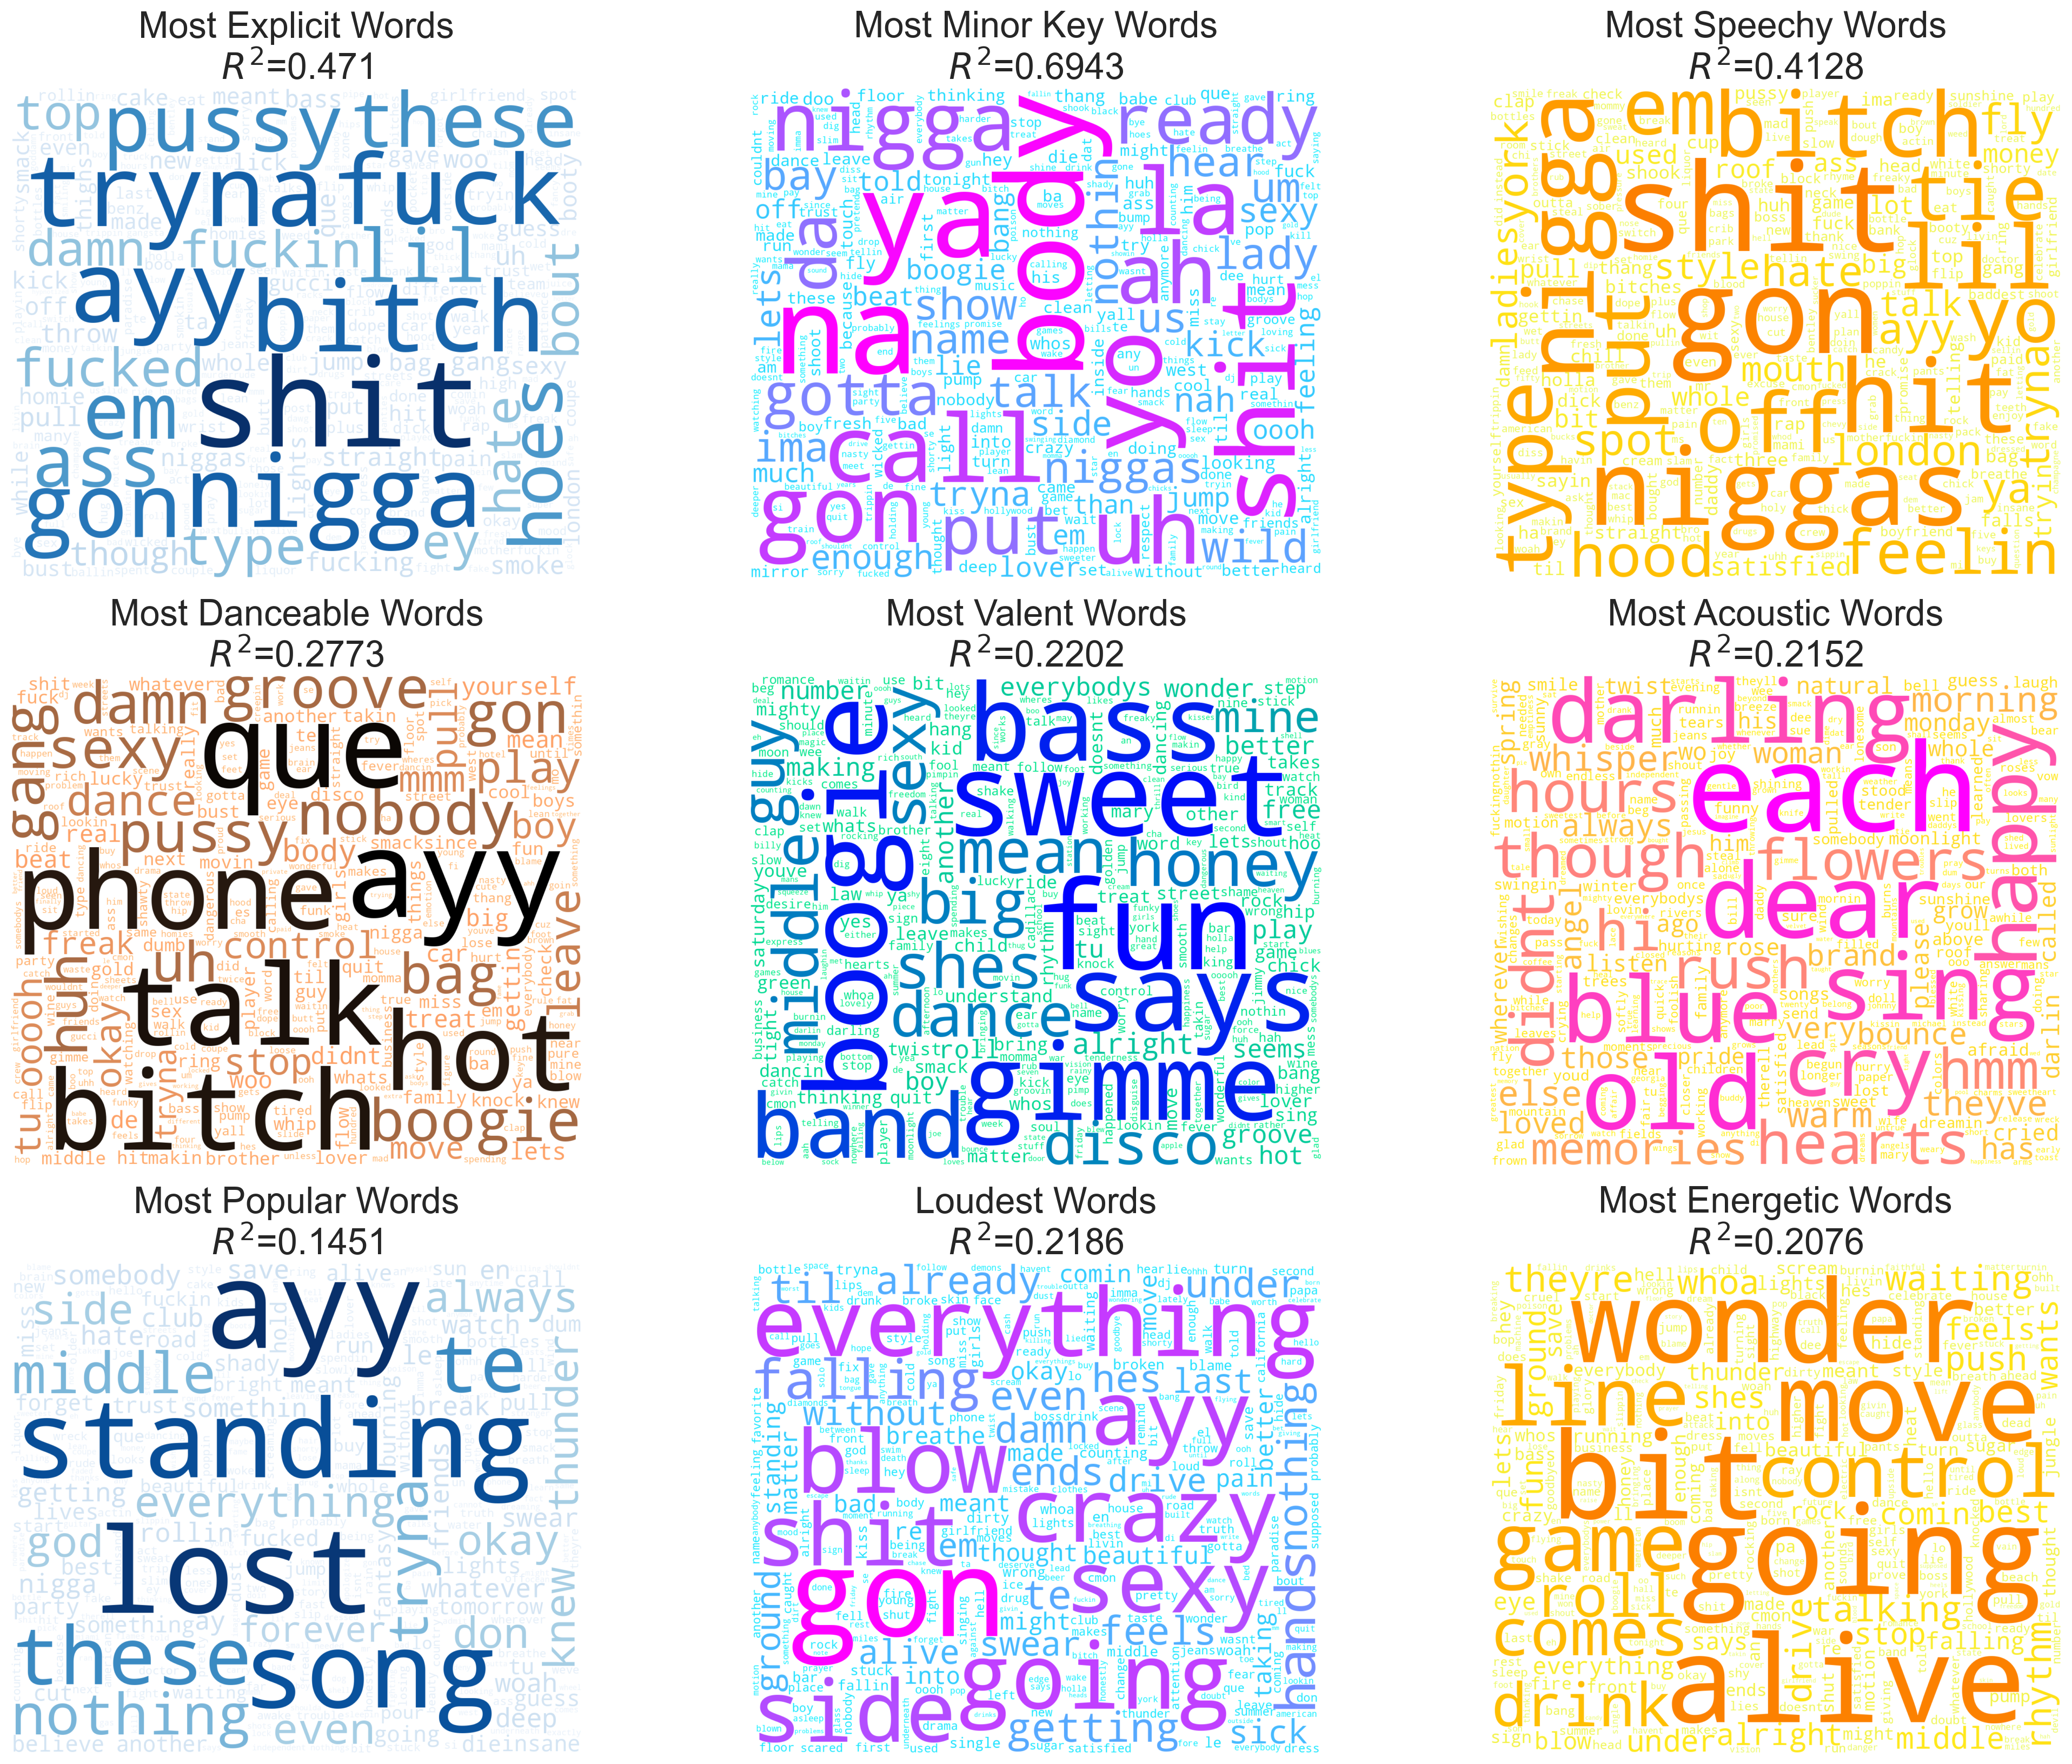

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(25, 20))
axes = axes.ravel()
audio_features = ['explicit', 'mode', 'speechiness', 'danceability', 'valence', 'acousticness', 'popularity', 'loudness', 'energy']
                
titles = ['most explicit words', 'most minor key words', 'most speechy words', 'most danceable words', 
          'most valent words', 'most acoustic words', 'most popular words', 'loudest words', 'most energetic words']

cmaps = ['Blues', 'cool', 'Wistia', 'copper_r', 'winter_r', 'spring_r'] * 3
cmaps = cmaps + cmaps

count = CountVectorizer(min_df=20, max_df=1000)
X_vect = count.fit_transform(df_nonnull['lyrics'])
for i, feature in enumerate(audio_features):
    if feature not in ['mode']:
        ridge = RidgeCV(alphas=[1, 3, 10, 30, 1e2, 3e2, 1e3, 2e3, 3e3, 4e3, 1e5, 3e5, 1e6])
        ridge.fit(X_vect, df_nonnull[feature])
        score = ridge.score(X_vect, df_nonnull[feature])
    else:
        ridge = LogisticRegressionCV(Cs=[1e-6, 3e-6, 1e-5, 3e-5])
        ridge.fit(X_vect, 1 - df_nonnull[feature])
        score = ridge.scores_[1.].mean(axis=1).max()
    coefs = ridge.coef_
    if feature in ['mode']:
        coefs = coefs.squeeze()
    vocab = count.get_feature_names_out()

    color_func = colormap_size_func(cmaps[i], 300)
    dictionary = dict(zip(vocab, coefs))
    wordcloud = WordCloud(background_color='white', height=1200,
                          min_font_size=5, width=1400, color_func=color_func,
                          max_words=300, relative_scaling=0.5,
                          max_font_size=300)
    wordcloud = wordcloud.generate_from_frequencies(dictionary)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set(title='{}\n$R^2$={:.4}'.format(titles[i], score).title())